# Import Modules and Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF 
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import pickle
from scipy.sparse import csr_matrix

#import fuzzywuzzy

In [2]:
plt.style.use('ggplot')

In [3]:
movies = pd.read_csv('movies.csv')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [4]:
movies.shape

(9742, 3)

In [5]:
#of films with ratings
movies['movieId'].nunique()

9742

In [6]:
df_ratings = pd.read_csv('ratings.csv')#, index_col='userId')
df_ratings.drop('timestamp', inplace=True, axis=1)
df_ratings.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


In [7]:
#of people that gave ratings
df_ratings['userId'].nunique()

610

In [8]:
movie_data=df_ratings.merge(movies, how='left', on='movieId')

In [9]:
movie_data.shape

(100836, 5)

In [10]:
movie_data['title'].nunique()

9719

In [11]:
movie_data.head(2)#.set_index('userId')

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance


# EDA

In [12]:
movie_ratings=pd.pivot_table(movie_data,index='userId',columns='title',values='rating')
movie_ratings.head(2)
movie_ratings_copy=movie_ratings

In [13]:
#Calculate the number of ratings per user, all users have rated minimum 20 films
movie_ratings.count(axis=1).reset_index(name='count').sort_values(by='count', ascending=True).head(5)

,userId,count
441,442,20
405,406,20
146,147,20
193,194,20
568,569,20


In [14]:
#check for missing values
movie_ratings.isna().sum()

title
'71 (2014)                                   609
'Hellboy': The Seeds of Creation (2004)      609
'Round Midnight (1986)                       608
'Salem's Lot (2004)                          609
'Til There Was You (1997)                    608
                                            ... 
eXistenZ (1999)                              588
xXx (2002)                                   586
xXx: State of the Union (2005)               605
¡Three Amigos! (1986)                        584
À nous la liberté (Freedom for Us) (1931)    609
Length: 9719, dtype: int64

### Top 10 rated movies

In [15]:
#the average rating of each movie, sorted highest to lowest 
#(this includes films with only 1 vote)
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Gena the Crocodile (1969)                    5.0
True Stories (1986)                          5.0
Cosmic Scrat-tastrophe (2015)                5.0
Love and Pigeons (1985)                      5.0
Red Sorghum (Hong gao liang) (1987)          5.0
Thin Line Between Love and Hate, A (1996)    5.0
Lesson Faust (1994)                          5.0
Eva (2011)                                   5.0
Who Killed Chea Vichea? (2010)               5.0
Siam Sunset (1999)                           5.0
Name: rating, dtype: float64

In [16]:
#the total number of ratings for a movie by votes (weighted ratings)
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64

### Convert the matrix into long format (with pd.melt())


In [17]:
movie_ratings=pd.pivot_table(movie_data,index='userId',columns='title',values='rating')
movie_ratings.head(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
long_format = pd.melt(movie_ratings.reset_index(),id_vars='userId',var_name='title',value_name='rating')

In [19]:
long_format.set_index('userId', inplace = True)

In [20]:
long_format.head()

,title,rating
userId,,
1,'71 (2014),NaN
2,'71 (2014),NaN
3,'71 (2014),NaN
4,'71 (2014),NaN
5,'71 (2014),NaN


# Build a Simple Recommender based on Correlations

In [21]:
simple_mean_ratings = pd.DataFrame(long_format.groupby('title')['rating'].mean().sort_values(ascending=False))

In [22]:
simple_mean_ratings.head(2)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0


In [23]:
#The rating of a movie is proportional to the total number of ratings it has. Therefore,\ 
#consider the total ratings cast for each movie.
simple_mean_ratings['Total Ratings'] = pd.DataFrame(long_format.groupby('title')['rating'].count())
#mean_ratings.head(5)

In [24]:
clean_movie=movie_ratings

In [25]:
clean_movie.fillna(value=0, inplace=True)
#curt.head()

**Select a movie to test recommender system**

In [26]:
#pick movies based on another movie
movie_pick='Groundhog Day (1993)'

In [27]:
recommendation = pd.DataFrame(clean_movie.corrwith(clean_movie[movie_pick]),columns=['Correlation'])
recommendation.dropna(inplace=True)

In [28]:
recommendation = recommendation.join(simple_mean_ratings['Total Ratings'])
recommendation.head()


,Correlation,Total Ratings
title,,
'71 (2014),0.084213,1
'Hellboy': The Seeds of Creation (2004),0.095990,1
'Round Midnight (1986),0.052519,2
'Salem's Lot (2004),-0.021777,1
'Til There Was You (1997),0.006481,2


In [29]:
#Let’s filter all the movies with a correlation value to the movie_pick

recc = recommendation.sort_values('Correlation',ascending=False).reset_index().head(11)
recc

,title,Correlation,Total Ratings
0,Groundhog Day (1993),1.000000,143
1,Ferris Bueller's Day Off (1986),0.490478,109
2,Back to the Future (1985),0.487406,171
3,Being John Malkovich (1999),0.486789,99
4,Monty Python and the Holy Grail (1975),0.486157,136
5,"Princess Bride, The (1987)",0.475713,142
6,Men in Black (a.k.a. MIB) (1997),0.467492,165
7,Ghostbusters (a.k.a. Ghost Busters) (1984),0.464628,120
8,Austin Powers: International Man of Mystery (1...,0.461074,100
9,Total Recall (1990),0.460165,88


# Non-Negative Matrix Factorization with KNN Imputer

In [30]:
movie_ratings_KNN=movie_ratings

In [31]:
users = movie_ratings_KNN.index.to_list()
binary = pickle.dumps(users)
file = open('users.bin',mode="wb")
file.write(binary)
file.close()

In [32]:
movie_list = movie_ratings_KNN.columns.to_list()
binary = pickle.dumps(movie_list)
file = open('movie_list.bin',mode="wb")
file.write(binary)
file.close()

In [33]:
knn_imputer = KNNImputer(n_neighbors=4)
binary = pickle.dumps(knn_imputer)
file = open('knn_imputer.bin',mode="wb")
file.write(binary)
file.close()

In [34]:
ratings_knn = pd.DataFrame(data=knn_imputer.fit_transform(movie_ratings_KNN),
            index=users,
            columns=movie_list)
ratings_knn.head(2)

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#per the notes, it stated for NMF to give decent results, we needed at least 20 components
nmf_model = NMF(n_components=20,init='random',random_state=10, max_iter=10000)

In [36]:
nmf_model.fit(movie_ratings_KNN)

NMF(init='random', max_iter=10000, n_components=20, random_state=10)

In [37]:
Q_matrix = nmf_model.components_
#Q_matrix

In [38]:
Q = pd.DataFrame(data=Q_matrix,
            index=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20'],
            columns=movie_list)
#Q.head()

In [39]:
P_matrix = nmf_model.transform(movie_ratings_KNN)
#P_matrix

In [40]:
P = pd.DataFrame(data=P_matrix,
                index=users,
                columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20'])
#P.head()

In [41]:
Rating_rec_matrix = np.dot(P_matrix,Q_matrix)

In [42]:
Rating_rec = pd.DataFrame(data=Rating_rec_matrix,
                         index=users,
                         columns=movie_list)
#Rating_rec.head(2)

## Reconstructed Error -NMF using KNN 

The reconstructed error is a measure of the sum of the distances. We are trying to minimise this! Euclidean norm of the matrix difference between  𝑅  and the reconstructed data  𝑅̂   from the fitted model.

In [43]:
NMF_KNN_error=nmf_model.reconstruction_err_
NMF_KNN_error

876.7273276841441

## Save the Model with pickle

In [44]:
binary = pickle.dumps(nmf_model)
#print(binary)

file = open('nmf_model.bin',mode="wb")
file.write(binary)
file.close()

In [45]:
#load a pickled model
file = open('nmf_model.bin',mode="rb")
binary = file.read()
#print(binary)
file.close()

In [46]:
nmf_model = pickle.loads(binary)
nmf_model

NMF(init='random', max_iter=10000, n_components=20, random_state=10)

## Provide a new user with movie-recommendations

In [47]:
new_user_query = {"Lord of the Rings": 10,
                 "Melancholia":7,
                 "Finding Nemo": 7,
                 "Godfather, The": 6,
                 "From Dusk Till Dawn": 1,
                 "Waterboy, The": 7,
                 "Like Water for Chocolate": 10,
                 "Face Off": 7,
                 "Spice World": 0}

In [48]:
new_user = pd.DataFrame(data=new_user_query,
                        columns=movie_list,
                        index = ["new_user"])
#new_user

In [49]:
new_user_imputed = pd.DataFrame(data=knn_imputer.transform(new_user),
                                 columns=movie_list,
                                 index = ["new_user"])
new_user_imputed

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
new_user,0.006557,0.006557,0.011475,0.008197,0.013115,0.002459,0.088525,0.004918,0.252459,0.037705,...,0.002459,0.053279,0.018033,0.009836,0.004918,0.139344,0.109016,0.016393,0.133607,0.001639


In [50]:
P_new_user_matrix = nmf_model.transform(new_user_imputed)
#P_new_user_matrix

Reconstruct the user-movie(item) matrix/dataframe for the new user

In [51]:
Reconstructed_new_user_ratings = pd.DataFrame(data=np.dot(P_new_user_matrix,Q),
                                              columns=movie_list,
                                              index=['new_user'])
Reconstructed_new_user_ratings

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
new_user,0.007941,0.011782,0.01112,0.001241,0.003655,0.004449,0.087826,0.003074,0.230933,0.037629,...,0.001993,0.039055,0.015793,0.012548,0.002832,0.138905,0.095517,0.013042,0.125337,0.001983


In [52]:
Recco_new_user=Reconstructed_new_user_ratings.T

In [53]:
#top 10 recommended movies
Recco_new_user.sort_values(by='new_user', ascending=False).index.tolist()[:11]

['Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Braveheart (1995)',
 'Fight Club (1999)',
 "Schindler's List (1993)",
 'Terminator 2: Judgment Day (1991)',
 'Jurassic Park (1993)']

# Non-Negative Matrix Factorization with Mean Movie Rating

In [54]:
mean_ratings=movie_ratings_copy
mean_ratings.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
for column in mean_ratings:
    mean_ratings.loc[:,column] = np.where(mean_ratings[column].isna(), mean_ratings[column].mean(), mean_ratings[column])

In [56]:
mean_ratings.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [57]:
users_mean_ratings = mean_ratings.index.to_list()
binary = pickle.dumps(users_mean_ratings)
file = open('users_mean_ratings.bin',mode="wb")
file.write(binary)
file.close()

In [58]:
movies_mean_ratings = mean_ratings.columns.to_list()
binary = pickle.dumps(movies_mean_ratings)
file = open('movies_mean_ratings.bin',mode="wb")
file.write(binary)
file.close()

In [59]:
nmf_model.fit(mean_ratings)

NMF(init='random', max_iter=10000, n_components=20, random_state=10)

In [60]:
nmf_model.components_.shape

(20, 9719)

In [61]:
Q_matrix_mean = nmf_model.components_

In [62]:
Q_mean = pd.DataFrame(data=Q_matrix_mean,
            index=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20'],
            columns=movies_mean_ratings)

In [63]:
nmf_model.transform(mean_ratings).shape

(610, 20)

In [64]:
P_matrix_mean = nmf_model.transform(mean_ratings)

In [65]:
P_matrix_mean.shape

(610, 20)

In [66]:
P_mean = pd.DataFrame(data=P_matrix_mean,
                index=users_mean_ratings,
                columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20'])


In [67]:
Rating_rec_matrix_mean = np.dot(P_matrix_mean,Q_matrix_mean)

In [68]:
Rating_rec_mean = pd.DataFrame(data=Rating_rec_matrix_mean,
                         index=users_mean_ratings,
                         columns=movies_mean_ratings)
Rating_rec_mean.head()

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
1,3.993987,4.019479,3.518448,4.992880,3.997108,1.499428,3.378996,3.004930,3.655691,3.278721,...,1.498440,4.062546,3.666273,3.014329,3.009556,3.767317,2.690542,2.002797,3.203469,0.999286
2,4.000259,4.000430,3.500368,5.000330,4.000570,1.500099,3.179985,3.000247,3.657151,3.287148,...,1.500097,4.066618,3.663539,3.000291,3.000285,3.862583,2.771105,1.999260,3.138892,1.000067
3,4.000688,3.997504,3.497661,5.000807,4.000716,1.500059,3.184875,2.999349,3.591997,3.282662,...,1.500177,4.075905,3.650546,2.998196,2.998763,3.891789,2.775820,1.996225,3.100066,1.000077
4,4.005765,3.993631,3.493694,5.007031,4.004477,1.501325,3.168172,2.999793,3.626051,3.268268,...,1.501813,4.086598,3.661698,2.995250,2.997616,3.825190,2.692445,1.998638,3.162763,1.001055
5,4.000236,4.002384,3.502169,5.000335,4.001013,1.500211,3.156482,3.000952,3.642186,3.285086,...,1.500137,4.067106,3.666314,3.001706,3.001355,3.855888,2.760215,2.000700,3.137336,1.000120


In [69]:
nmf_model_mean_error=nmf_model.reconstruction_err_
nmf_model_mean_error

239.89835403130832

## Recommend Movies to new user

In [70]:
new_user_query = {"Lord of the Rings": 10,
                 "Melancholia":7,
                 "Finding Nemo": 7,
                 "Godfather, The": 6,
                 "From Dusk Till Dawn": 1,
                 "Waterboy, The": 7,
                 "Like Water for Chocolate": 10,
                 "Face Off": 7,
                 "Spice World": 0}

In [71]:
new_user_mean = pd.DataFrame(data=new_user_query,
                        columns=movies_mean_ratings,
                        index = ["new_user"])


In [72]:
new_user_mean_imputed = pd.DataFrame(data=knn_imputer.transform(new_user_mean),
                                 columns=movies_mean_ratings,
                                 index = ["new_user"])

In [73]:
P_new_user_matrix_mean = nmf_model.transform(new_user_mean_imputed)

In [74]:
Reconstructed_new_user_mean_ratings = pd.DataFrame(data=np.dot(P_new_user_matrix_mean,Q_mean),
                                              columns=movies_mean_ratings,
                                              index=['new_user'])

In [75]:
Recco_new_user_mean=Reconstructed_new_user_mean_ratings.T
#Recco_new_user_mean

In [76]:
#top 10 recommended movies
Recco_new_user_mean.sort_values(by='new_user', ascending=False).index.tolist()[:11]

['Braveheart (1995)',
 'Forrest Gump (1994)',
 'Fight Club (1999)',
 'Mrs. Doubtfire (1993)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Sixth Sense, The (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Matrix, The (1999)',
 'Toy Story (1995)',
 'Santa Clause, The (1994)',
 'Shawshank Redemption, The (1994)']

## Reconstructed Error using NMF_Mean

In [77]:
NMF_mean_error=nmf_model.reconstruction_err_
NMF_mean_error

239.89835403130832

# Non-Negative Matrix Factorization with Movies Rated 20+ times

In [78]:
movie_ratings.head(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
out_filter = movie_ratings.count() > 20

In [80]:
movies_rated_20=movie_ratings.loc[:,out_filter]
movies_rated_20.head(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
users_20 = movies_rated_20.index.to_list()
binary = pickle.dumps(users_20)
file = open('users_20.bin',mode="wb")
file.write(binary)
file.close()

In [82]:
movie_list_20 = movies_rated_20.columns.to_list()
binary = pickle.dumps(movie_list_20)
file = open('movie_list_20.bin',mode="wb")
file.write(binary)
file.close()

In [83]:
nmf_model.fit(movies_rated_20)

NMF(init='random', max_iter=10000, n_components=20, random_state=10)

In [84]:
nmf_model.components_.shape

(20, 9719)

In [142]:
nmf_model.fit_transform(movies_rated_20).shape

(610, 20)

In [143]:
Q_matrix_20 = nmf_model.components_

In [144]:
Q_20 = pd.DataFrame(data=Q_matrix_20,
            index=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20'],
            columns=movie_list_20)

In [145]:
nmf_model.transform(movies_rated_20).shape


(610, 20)

In [146]:
P_matrix_20 = nmf_model.transform(movies_rated_20)

In [147]:
P_matrix_20.shape

(610, 20)

In [148]:
P_20 = pd.DataFrame(data=P_matrix_20,
                index=users_20,
                columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20'])


In [149]:
Rating_rec_matrix_20 = np.dot(P_matrix_20,Q_matrix_20)

In [150]:
Rating_rec_20 = pd.DataFrame(data=Rating_rec_matrix_20,
                         index=users_20,
                         columns=movie_list_20)

In [151]:
nmf_model_20_error=nmf_model.reconstruction_err_
nmf_model_20_error

876.7273276841441

## Recommend movies

In [95]:
new_user_query = {"Lord of the Rings": 10,
                 "Melancholia":7,
                 "Finding Nemo": 7,
                 "Godfather, The": 6,
                 "From Dusk Till Dawn": 1,
                 "Waterboy, The": 7,
                 "Like Water for Chocolate": 10,
                 "Face Off": 7,
                 "Spice World": 0}

In [96]:
new_user_20 = pd.DataFrame(data=new_user_query,
                        columns=movie_list_20,
                        index = ["new_user"])

In [97]:
new_user_20_imputed = pd.DataFrame(data=knn_imputer.transform(new_user_20),
                                 columns=movie_list_20,
                                 index = ["new_user"])

In [98]:
P_new_user_matrix_20 = nmf_model.transform(new_user_20_imputed)

In [99]:
Reconstructed_new_user_20_ratings = pd.DataFrame(data=np.dot(P_new_user_matrix_20,Q_20),
                                              columns=movie_list_20,
                                              index=['new_user'])

In [100]:
Recco_new_user_20=Reconstructed_new_user_20_ratings.T

In [101]:
#top 10 recommended movies
Recco_new_user_20.sort_values(by='new_user', ascending=False).index.tolist()[:11]

['Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Braveheart (1995)',
 'Fight Club (1999)',
 "Schindler's List (1993)",
 'Terminator 2: Judgment Day (1991)',
 'Jurassic Park (1993)']

# Collaborative User Based Filtering-K-Means

In [102]:
ratings2 = pd.read_csv('ratings.csv', usecols = ['userId', 'movieId','rating'])

In [103]:
#movie_ratings.head(2)

In [104]:
# Filtering data for ratings 0 or higher
ratings3 = ratings2[ratings2['rating'] >= 0]
ratings3

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [105]:
ratings3.isna().count()

userId     100836
movieId    100836
rating     100836
dtype: int64

In [106]:
movies = pd.read_csv('movies.csv')

In [107]:
movies['movieId'].nunique()

9742

In [108]:
full_ratings=ratings3.merge(movies, how='left', on='movieId')
full_ratings.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [109]:
kmeans_ratings=full_ratings[['userId','rating', 'title']]

In [110]:
kmeans_ratings.nunique()

userId     610
rating      10
title     9719
dtype: int64

In [111]:
#list of unique users
users_KMeans = np.unique(kmeans_ratings['userId'])
users_KMeans.shape

#binary = pickle.dumps(users_KMeans)
#file = open('users_KMeans.bin',mode="wb")
#file.write(binary)
#file.close()

(610,)

In [112]:
movie_list_KMeans=np.unique(kmeans_ratings['title'])
movie_list_KMeans.shape

#binary = pickle.dumps(movie_list_KMeans)
#file = open('movie_list_KMeans.bin',mode="wb")
#file.write(binary)
#file.close()

(9719,)

In [113]:
ratings_KMeans=pd.pivot_table(kmeans_ratings,index='userId',columns='title',values='rating')


In [114]:
ratings_KMeans.fillna(value=0, inplace=True)

In [115]:
#for K-Means, we must transform the matrix so movies are rows and users are columns
df_new_rating = ratings_KMeans.T
df_new_rating.head(2)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
#per the notes, it stated for NMF to give decent results, we needed at least 20 components
nmf_model = NMF(n_components=20,init='random',random_state=10, max_iter=10000)

In [117]:
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_new_rating.values)
mat_movie_features

<9719x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100832 stored elements in Compressed Sparse Row format>

Our data has a very high dimensionality, therefore KNN’s performance will suffer\ 
from the curse of dimensionality if it uses “euclidean distance” in its objective
function. Euclidean distance is unhelpful in high dimensions because all vectors\
are almost equidistant to the search query vector (target movie’s features).
Instead, we will use cosine similarity for nearest neighbor search.

Inertia: Intuitively, inertia tells how far away the points within a cluster are. Therefore, a small of inertia is aimed for. The range of inertia’s value starts from zero and goes up.

In [118]:
inertia = []
for i in range(1,13):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_new_rating)
    inertia.append(kmeans.inertia_)

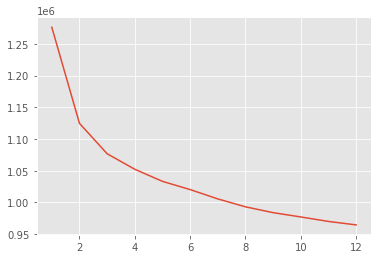

In [119]:
plt.plot(range(1, 13), inertia)

In [120]:
kmeans = KMeans(n_clusters=13)
kmeans.fit(df_new_rating)

KMeans(n_clusters=13)

In [121]:
predictions=kmeans.fit_predict(mat_movie_features)

Silhouette score: Silhouette score tells how far away the datapoints in one cluster are, from the datapoints in another cluster. The range of silhouette score is from -1 to 1. Score should be closer to 1 than -1.

In [122]:
 silhouette_score(df_new_rating, kmeans.labels_)

0.021359303995535255

In [123]:
kmeans.labels_

array([4, 4, 4, ..., 4, 8, 4], dtype=int32)

In [124]:
kmeans.cluster_centers_

array([[0.00000000e+00, 4.40414508e-02, 1.29533679e-03, ...,
        2.57772021e-01, 0.00000000e+00, 2.56088083e+00],
       [1.09144543e-01, 2.21238938e-03, 4.05604720e-03, ...,
        3.83112094e-01, 2.21238938e-03, 3.17477876e-01],
       [2.31578947e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.67894737e+00, 0.00000000e+00, 2.27894737e+00],
       ...,
       [3.57142857e-01, 5.95238095e-01, 1.19047619e-02, ...,
        3.28571429e+00, 0.00000000e+00, 3.80952381e+00],
       [4.02684564e-02, 0.00000000e+00, 9.58772771e-04, ...,
        4.12272291e-02, 5.75263663e-03, 5.75263663e-02],
       [0.00000000e+00, 2.64084507e-01, 0.00000000e+00, ...,
        1.08098592e+00, 0.00000000e+00, 3.45422535e+00]])

# Nearest Neighbor Model

In [125]:
model_NN = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=None)

In [126]:
model_NN.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [127]:
# create the movie similarity matrix
movie_similarity_matrix = cosine_similarity(mat_movie_features, dense_output=True)
#movie_similarity_matrix

In [128]:
user_similarity=pd.DataFrame(movie_similarity_matrix)
#user_similarity

In [129]:
binary = pickle.dumps(model_NN)
file = open('model_NN.bin',mode="wb")
file.write(binary)
file.close()

## Make Recommendations based on other movies (Item-Item)
create the matrix of movie titles and corresponding user ratings

In [130]:
item_user_rating=pd.pivot_table(movie_data,index='movieId',columns='userId',values='rating')
item_user_rating.fillna(value=0, inplace=True)
item_user_rating


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
# create the movie similarity matrix
movie_similarity_matrix = cosine_similarity(item_user_rating, dense_output=True)
movie_similarity_matrix

array([[1.        , 0.41056206, 0.2969169 , ..., 0.        , 0.        ,
        0.        ],
       [0.41056206, 1.        , 0.28243799, ..., 0.        , 0.        ,
        0.        ],
       [0.2969169 , 0.28243799, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [132]:
d=pd.DataFrame(movie_similarity_matrix)
d

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


# User-User Filtering

In [133]:
user_user_rating=pd.pivot_table(movie_data,index='userId',columns='movieId',values='rating')
user_user_rating.fillna(value=0, inplace=True)
user_user_rating


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# create the movie similarity matrix
user_similarity_matrix = cosine_similarity(user_user_rating, dense_output=True)
user_similarity_matrix


array([[1.        , 0.02728287, 0.05972026, ..., 0.29109737, 0.09357193,
        0.14532081],
       [0.02728287, 1.        , 0.        , ..., 0.04621095, 0.0275654 ,
        0.10242675],
       [0.05972026, 0.        , 1.        , ..., 0.02112846, 0.        ,
        0.03211875],
       ...,
       [0.29109737, 0.04621095, 0.02112846, ..., 1.        , 0.12199271,
        0.32205486],
       [0.09357193, 0.0275654 , 0.        , ..., 0.12199271, 1.        ,
        0.05322546],
       [0.14532081, 0.10242675, 0.03211875, ..., 0.32205486, 0.05322546,
        1.        ]])

In [135]:
e=pd.DataFrame(user_similarity_matrix)
e

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,1.000000,0.053225


In [139]:
df

,model,value
0,NMF KNN,876.727328
1,NMF using mean ratings,239.898354
2,NMF films rated 20 times or more,876.727328
